In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import re
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
import utils
df_raw = pd.read_csv('data/summary_listings.csv', low_memory=False, dtype=utils.schema)
df_raw.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group               float64
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [3]:
TARGET = 'price'

# Feature Engineering - Text Processing on Name

In [4]:
import matplotlib.font_manager as fm
import jieba
from wordcloud import WordCloud, STOPWORDS

In [5]:
# !wget https://src.fedoraproject.org/lookaside/extras/adobe-source-han-sans-cn-fonts/SourceHanSansCN.zip/sha512/898185dfe76425f929b014dfb5e47ba9a77f1cacfb07d68d3f530dd1f2cc7f596910cda36e5b237b12cead9c6f15a13d6ff20ad7b4d5748ef12fa3e1d637b70b/SourceHanSansCN.zip
# !unzip -j "SourceHanSansCN.zip" "SourceHanSansCN-Regular.otf" -d "."
# !ls
font_path = 'SourceHanSansCN-Regular.otf'

In [6]:
font_path = 'SourceHanSansCN-Regular.otf'
prop = fm.FontProperties(fname=font_path, size=20)
stopwords = set(STOPWORDS)

def get_wordcloud(data, font_path=font_path):
    return WordCloud(
        background_color='white',
        stopwords=stopwords,
        font_path=font_path,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))


def show_wordcloud(wordcloud, title = None):
    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        prop = fm.FontProperties(fname=font_path)
        fig.suptitle(title, fontsize=40, fontproperties=prop)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

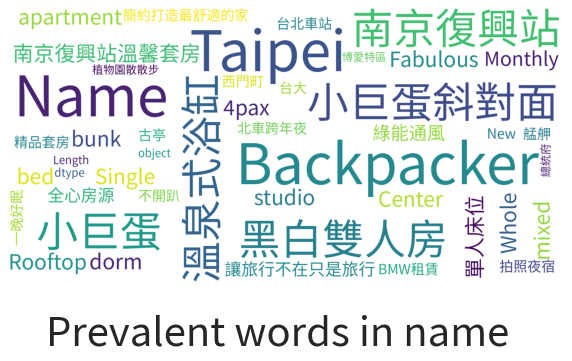

In [7]:
wordcloud = get_wordcloud(df_raw['name'], font_path)
show_wordcloud(wordcloud, title = 'Prevalent words in name')

In [8]:
cuttedNames = []
for name in df_raw['name']:
    cutted = jieba.cut(name, cut_all=False)
    cuttedNames.append(cutted)

In [9]:
import os.path
import json
WORD_FREQ_FILE = 'model/wordFreq.json'
freq = {}
if os.path.isfile(WORD_FREQ_FILE):
    with open(WORD_FREQ_FILE, 'rb') as f:
        freq = json.load(f)
else:
    cuttedNames = []
    for name in df_raw['name']:
        cutted = jieba.cut(name, cut_all=False)
        cuttedNames.append(cutted)
    for cuttedName in cuttedNames:
        try:
            for word in cuttedName:
                if word in freq:
                    freq[word] += 1
                else:
                    freq[word] = 1
        except Exception as e:
            pass
    with open(WORD_FREQ_FILE, 'w') as f:
        json.dump(freq, f)

In [10]:
freqItems = [item for item in freq.items() if len(item[0]) > 1]
sortedFreq = sorted(freqItems, key=lambda item: item[1],reverse=True)

In [11]:
keys = [key for (key, value) in sortedFreq[:200]]
uselessKeys = ['in', 'min', 'near', 'for', 'with', 'and', 'of', 'from', 'to', 'mins']
keys = [key for key in keys if key not in uselessKeys]

In [12]:
df_raw.name.fillna(value=0, inplace=True)
for key in keys:
    df_raw[key] = df_raw['name'].str.contains(keys[0]).fillna(0).astype(int)

# Feature Engineering - Neighborhood Pricing

In [13]:
mean_prices = []
locations = df_raw[['longitude', 'latitude']]
for index, row in locations.iterrows():
    long = row[0]
    lat = row[1]
    diff_long = (locations['longitude'] - long) * 100
    diff_lat = (locations['latitude'] - lat) * 100
    dist = np.sqrt((diff_long*diff_long + diff_lat*diff_lat))
    mean_prices.append(np.mean(df_raw[dist < 0.2][TARGET]))

In [14]:
df_raw['neighbor_price'] = mean_prices

# Imputing Data

In [15]:
df_raw.isna().sum()

id                         0
name                       0
host_id                    0
host_name                 22
neighbourhood_group    51887
                       ...  
捷运                         0
at                         0
Free                       0
信義                         0
neighbor_price             0
Length: 207, dtype: int64

In [16]:
df_train = df_raw.drop(columns=['neighbourhood_group', 'name', 'host_name', 'last_review'])
df_train.reviews_per_month.fillna(value=0, inplace=True)
df_train['neighbourhood'] = df_train.neighbourhood.astype('category')
df_train['room_type'] = df_train.room_type.astype('category')
df_target = df_train[[TARGET]]
df_train.drop(columns=[TARGET], inplace=True)
df_train.dtypes

id                   int64
host_id              int64
neighbourhood     category
latitude           float64
longitude          float64
                    ...   
捷运                   int64
at                   int64
Free                 int64
信義                   int64
neighbor_price     float64
Length: 202, dtype: object

In [17]:
# one-hot encoding of categorical features
cat_feats = df_train.select_dtypes(include=['category']).copy()
cat_feats_original_names = cat_feats.columns
cat_feats = pd.get_dummies(cat_feats)
df_train_encoded = pd.concat([df_train, cat_feats], axis=1)
df_train_encoded.drop(columns=cat_feats_original_names, inplace=True)
df_train_encoded

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,MRT,...,neighbourhood_士林區,neighbourhood_大同區,neighbourhood_大安區,neighbourhood_文山區,neighbourhood_松山區,neighbourhood_萬華區,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,74641,393116,25.05159,121.54747,3,49,0.47,4,88,0,...,0,0,0,0,1,0,0,0,1,0
1,74643,393116,25.05067,121.54568,3,52,0.46,4,90,0,...,0,0,0,0,1,0,0,0,1,0
2,178036,851825,25.04446,121.51346,1,77,0.71,9,149,0,...,0,0,0,0,0,0,0,1,0,0
3,271733,242033,25.00384,121.55573,5,60,0.58,1,52,0,...,0,0,0,1,0,0,1,0,0,0
4,289296,1338052,25.04335,121.55007,28,25,0.37,3,365,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51882,47340531,342671760,25.06185,121.52401,1,0,0.00,4,85,0,...,0,0,0,0,0,0,1,0,0,0
51883,47340779,342671760,25.06049,121.52217,1,0,0.00,4,0,0,...,0,0,0,0,0,0,1,0,0,0
51884,47340989,342671760,25.06086,121.52301,1,0,0.00,4,85,0,...,0,0,0,0,0,0,1,0,0,0
51885,47352089,195544407,25.05092,121.51417,1,0,0.00,1,0,0,...,0,1,0,0,0,0,1,0,0,0


# Split and Scale Data

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# split our data
X_train, X_test, y_train, y_test = train_test_split(df_train_encoded, df_target, test_size=0.2)

In [19]:
X_train.shape

(41509, 216)

In [20]:
cvbooster = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0)

In [22]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [200, 500],
              'learning_rate': [0.05, 0.1], 
              'max_depth': [7, 10],
              'colsample_bytree': [0.6, 0.7],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(cvbooster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}


In [23]:
bestparams = booster_grid_search.best_params_
bestparams

{'colsample_bytree': 0.6,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 500}

# Final Model Training and Test Score

In [24]:
# instantiate xgboost with best parameters
best_booster = xgb.XGBRegressor(
    colsample_bytree=bestparams['colsample_bytree'],
    gamma=bestparams['gamma'],
    learning_rate=bestparams['learning_rate'],
    max_depth=bestparams['max_depth'],
    n_estimators=bestparams['n_estimators'],
    random_state=4,
    tree_method='gpu_hist',
    gpu_id=0
)

# train
best_booster.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.1, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=12, num_parallel_tree=1, random_state=4,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [25]:
# predict
y_pred_test = best_booster.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 1861.7329


# Model Export

In [26]:
from datetime import datetime
from os.path import join
model_folder = "model"
model_name = "betterfe_{}.json".format(datetime.now().strftime("%Y%m%d_%H%M%S"))
model_path = join(model_folder, model_name)
best_booster.save_model(model_path)

# Forecast with Holdout

In [27]:
model = xgb.XGBRegressor()
model.load_model(model_path)

In [28]:
holdout = pd.read_csv('data/holdout/listings202103.csv', low_memory=False, dtype=utils.schema)

In [29]:
holdout.name.fillna(value=0, inplace=True)
for key in keys:
    holdout[key] = holdout['name'].str.contains(keys[0]).fillna(0).astype(int)
holdout_mean_prices = []
holdout_locations = holdout[['longitude', 'latitude']]
locations = df_raw[['longitude', 'latitude']]
for index, row in holdout_locations.iterrows():
    long = row[0]
    lat = row[1]
    diff_long = (locations['longitude'] - long) * 100
    diff_lat = (locations['latitude'] - lat) * 100
    dist = np.sqrt((diff_long*diff_long + diff_lat*diff_lat))
    neiboring_points = df_raw[dist < 0.2]
    holdout_mean_prices.append(np.mean(neiboring_points[TARGET]))
holdout['neighbor_price'] = holdout_mean_prices
holdout = holdout.drop(columns=['neighbourhood_group', 'name', 'host_name', 'last_review'])
holdout.reviews_per_month.fillna(value=0, inplace=True)
holdout['neighbourhood'] = holdout.neighbourhood.astype('category')
holdout['room_type'] = holdout.room_type.astype('category')
y_holdout = holdout[TARGET]
holdout.drop(columns=[TARGET], inplace=True)
holdout.dtypes

cat_feats = holdout.select_dtypes(include=['category']).copy()
cat_feats_original_names = cat_feats.columns
cat_feats = pd.get_dummies(cat_feats)
holdout_encoded = pd.concat([holdout, cat_feats], axis=1)
holdout_encoded.drop(columns=cat_feats_original_names, inplace=True)
holdout_encoded

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,MRT,...,neighbourhood_士林區,neighbourhood_大同區,neighbourhood_大安區,neighbourhood_文山區,neighbourhood_松山區,neighbourhood_萬華區,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,74641,393116,25.05343,121.54621,3,49,0.43,2,89,0,...,0,0,0,0,1,0,0,0,1,0
1,178036,851825,25.04446,121.51346,1,81,0.69,9,0,0,...,0,0,0,0,0,0,0,1,0,0
2,271733,242033,25.00581,121.55518,5,64,0.57,1,120,0,...,0,0,0,1,0,0,1,0,0,0
3,289296,1338052,25.04287,121.55112,28,25,0.32,2,365,0,...,0,0,1,0,0,0,1,0,0,0
4,289298,1338052,25.08091,121.55902,1,186,1.93,2,350,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,48846513,9544894,25.03133,121.55798,30,0,0.00,2,171,0,...,0,0,0,0,0,0,1,0,0,0
5255,48853952,102493558,25.10214,121.52381,5,0,0.00,2,87,0,...,1,0,0,0,0,0,0,0,0,1
5256,48854439,221534550,25.02530,121.49680,30,0,0.00,42,90,1,...,0,0,0,0,0,1,1,0,0,0
5257,48855237,298910458,25.04866,121.55076,2,0,0.00,4,90,1,...,0,0,0,0,1,0,1,0,0,0


In [30]:
# predict

y_pred = model.predict(holdout_encoded)
RMSE = np.sqrt(mean_squared_error(y_holdout,y_pred))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 5702.5136


# Opotimize Model

<BarContainer object of 15 artists>

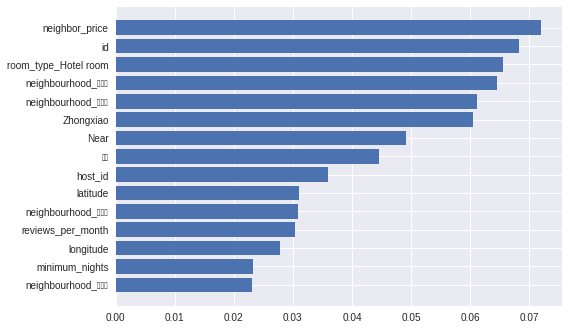

In [31]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx[-15:]], model.feature_importances_[sorted_idx[-15:]])

In [32]:
import utils
df_raw = pd.read_csv('data/summary_listings.csv', low_memory=False, dtype=utils.schema)

In [33]:
mean_prices = []
locations = df_raw[['longitude', 'latitude']]
for index, row in locations.iterrows():
    long = row[0]
    lat = row[1]
    diff_long = (locations['longitude'] - long) * 100
    diff_lat = (locations['latitude'] - lat) * 100
    dist = np.sqrt((diff_long*diff_long + diff_lat*diff_lat))
    mean_prices.append(np.mean(df_raw[dist < 0.2][TARGET]))

In [34]:
df_raw['neighbor_price'] = mean_prices

In [35]:
df_train = df_raw.drop(columns=['neighbourhood_group', 'name', 'host_name', 'last_review'])
df_train.reviews_per_month.fillna(value=0, inplace=True)
df_train['neighbourhood'] = df_train.neighbourhood.astype('category')
df_train['room_type'] = df_train.room_type.astype('category')
df_target = df_train[[TARGET]]
df_train.drop(columns=[TARGET], inplace=True)
# one-hot encoding of categorical features
cat_feats = df_train.select_dtypes(include=['category']).copy()
cat_feats_original_names = cat_feats.columns
cat_feats = pd.get_dummies(cat_feats)
df_train_encoded = pd.concat([df_train, cat_feats], axis=1)
df_train_encoded.drop(columns=cat_feats_original_names, inplace=True)
df_train_encoded

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbor_price,...,neighbourhood_士林區,neighbourhood_大同區,neighbourhood_大安區,neighbourhood_文山區,neighbourhood_松山區,neighbourhood_萬華區,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,74641,393116,25.05159,121.54747,3,49,0.47,4,88,1835.519231,...,0,0,0,0,1,0,0,0,1,0
1,74643,393116,25.05067,121.54568,3,52,0.46,4,90,1962.890411,...,0,0,0,0,1,0,0,0,1,0
2,178036,851825,25.04446,121.51346,1,77,0.71,9,149,2871.957143,...,0,0,0,0,0,0,0,1,0,0
3,271733,242033,25.00384,121.55573,5,60,0.58,1,52,3317.783784,...,0,0,0,1,0,0,1,0,0,0
4,289296,1338052,25.04335,121.55007,28,25,0.37,3,365,1986.739884,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51882,47340531,342671760,25.06185,121.52401,1,0,0.00,4,85,2431.544186,...,0,0,0,0,0,0,1,0,0,0
51883,47340779,342671760,25.06049,121.52217,1,0,0.00,4,0,2392.455056,...,0,0,0,0,0,0,1,0,0,0
51884,47340989,342671760,25.06086,121.52301,1,0,0.00,4,85,2272.305936,...,0,0,0,0,0,0,1,0,0,0
51885,47352089,195544407,25.05092,121.51417,1,0,0.00,1,0,2562.379906,...,0,1,0,0,0,0,1,0,0,0


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# split our data
X_train, X_test, y_train, y_test = train_test_split(df_train_encoded, df_target, test_size=0.2)

In [37]:
cvbooster = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0)

In [38]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [200, 500],
              'learning_rate': [0.05, 0.1], 
              'max_depth': [7, 10],
              'colsample_bytree': [0.6, 0.7],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(cvbooster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}


In [39]:
# instantiate xgboost with best parameters
best_booster = xgb.XGBRegressor(
    colsample_bytree=bestparams['colsample_bytree'],
    gamma=bestparams['gamma'],
    learning_rate=bestparams['learning_rate'],
    max_depth=bestparams['max_depth'],
    n_estimators=bestparams['n_estimators'],
    random_state=4,
    tree_method='gpu_hist',
    gpu_id=0
)

# train
best_booster.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.1, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=12, num_parallel_tree=1, random_state=4,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [40]:
# predict
y_pred_test = best_booster.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 2504.9744


In [41]:
from datetime import datetime
from os.path import join
model_folder = "model"
model_name = "betterfe_{}.json".format(datetime.now().strftime("%Y%m%d_%H%M%S"))
model_path = join(model_folder, model_name)
best_booster.save_model(model_path)

In [42]:
model = xgb.XGBRegressor()
model.load_model(model_path)

In [43]:
holdout = pd.read_csv('data/holdout/listings202103.csv', low_memory=False, dtype=utils.schema)

In [44]:
holdout.name.fillna(value=0, inplace=True)
holdout_mean_prices = []
holdout_locations = holdout[['longitude', 'latitude']]
locations = df_raw[['longitude', 'latitude']]
for index, row in holdout_locations.iterrows():
    long = row[0]
    lat = row[1]
    diff_long = (locations['longitude'] - long) * 100
    diff_lat = (locations['latitude'] - lat) * 100
    dist = np.sqrt((diff_long*diff_long + diff_lat*diff_lat))
    neiboring_points = df_raw[dist < 0.2]
    holdout_mean_prices.append(np.mean(neiboring_points[TARGET]))
holdout['neighbor_price'] = holdout_mean_prices
holdout = holdout.drop(columns=['neighbourhood_group', 'name', 'host_name', 'last_review'])
holdout.reviews_per_month.fillna(value=0, inplace=True)
holdout['neighbourhood'] = holdout.neighbourhood.astype('category')
holdout['room_type'] = holdout.room_type.astype('category')
y_holdout = holdout[TARGET]
holdout.drop(columns=[TARGET], inplace=True)
holdout.dtypes

cat_feats = holdout.select_dtypes(include=['category']).copy()
cat_feats_original_names = cat_feats.columns
cat_feats = pd.get_dummies(cat_feats)
holdout_encoded = pd.concat([holdout, cat_feats], axis=1)
holdout_encoded.drop(columns=cat_feats_original_names, inplace=True)
holdout_encoded

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbor_price,...,neighbourhood_士林區,neighbourhood_大同區,neighbourhood_大安區,neighbourhood_文山區,neighbourhood_松山區,neighbourhood_萬華區,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,74641,393116,25.05343,121.54621,3,49,0.43,2,89,2878.257143,...,0,0,0,0,1,0,0,0,1,0
1,178036,851825,25.04446,121.51346,1,81,0.69,9,0,2871.957143,...,0,0,0,0,0,0,0,1,0,0
2,271733,242033,25.00581,121.55518,5,64,0.57,1,120,4402.375000,...,0,0,0,1,0,0,1,0,0,0
3,289296,1338052,25.04287,121.55112,28,25,0.32,2,365,2086.596429,...,0,0,1,0,0,0,1,0,0,0
4,289298,1338052,25.08091,121.55902,1,186,1.93,2,350,3138.488372,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,48846513,9544894,25.03133,121.55798,30,0,0.00,2,171,2508.305556,...,0,0,0,0,0,0,1,0,0,0
5255,48853952,102493558,25.10214,121.52381,5,0,0.00,2,87,1217.812500,...,1,0,0,0,0,0,0,0,0,1
5256,48854439,221534550,25.02530,121.49680,30,0,0.00,42,90,2032.006711,...,0,0,0,0,0,1,1,0,0,0
5257,48855237,298910458,25.04866,121.55076,2,0,0.00,4,90,1518.000000,...,0,0,0,0,1,0,1,0,0,0


In [45]:
# predict

y_pred = model.predict(holdout_encoded)
RMSE = np.sqrt(mean_squared_error(y_holdout,y_pred))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 4220.8731
